# Backtest Example

## 1. 环境设置

In [11]:
# -*- encoding: utf-8 -*-
import time
import pandas as pd
import numpy as np
import statsmodels.api as sm
from jaqs.data import DataApi

from jaqs.data import RemoteDataService
from jaqs.trade import AlphaBacktestInstance
from jaqs.trade import PortfolioManager
import matplotlib.pyplot as plt
#from jaqs.trade import RealTimeTradeApi
%matplotlib inline
import jaqs.util as jutil
import jaqs.trade.analyze as ana
from jaqs.trade import AlphaStrategy
from jaqs.trade import AlphaTradeApi
from jaqs.trade import model
from jaqs.data import DataView

In [2]:
# 设置文件存储路径
dataview_dir_path = '../output/backtest/dataview'
backtest_result_dir_path = 'backtest'
backtest_result_folder = '../output/backtest'
# 设置服务器地址、用户名密码
# 例如：
# data_config = {
#   "remote.data.address": "tcp://data.quantos.org:8910",
#   "remote.data.username":  '18688888888',
#   "remote.data.password":  '23sdjfk209d0fs9dejkl2j3k4j9d0fsdf'}

# 如果没有使用quantos金融终端，请自行替换phone,token内容
import os
phone = os.environ.get("QUANTOS_USER")
token = os.environ.get("QUANTOS_TOKEN")

data_config = {
  "remote.data.address": "tcp://data.quantos.org:8910",
  "remote.data.username":  phone,
  "remote.data.password":  token}
trade_config = {
  "remote.trade.address": "tcp://gw.quantos.org:8901",
  "remote.trade.username":  phone,
  "remote.trade.password":  token}
# RemoteDataService communicates with a remote server to fetch data
ds = RemoteDataService()
# Use username and password in data_config to login
ds.init_from_config(data_config)


Begin: DataApi login 17321165656@tcp://data.quantos.org:8910
    login success 



'0,'

## 设置参数

In [3]:
UNIVERSE = '000300.SH'
START_DATE = 20151207
END_DATE = 20180531

## 准备DataView

In [4]:
dataview_props = {# Start and end date of back-test
                  'start_date': START_DATE, 'end_date': END_DATE,
                  # Investment universe and performance benchmark
                  'universe': UNIVERSE, 'benchmark': UNIVERSE,
                  # Data fields that we need
                  'fields': 'pe_ttm,total_mv,sw1',
                  # freq = 1 means we use daily data. Please do not change this.
                  'freq': 1}

# DataView utilizes RemoteDataService to get various data and store them
dv = DataView()
dv.init_from_config(dataview_props, ds)
dv.prepare_data()

Initialize config success.
Query data...
Query data - query...
NOTE: price adjust method is [post adjust]
238
477
238
477
46
93
140
187
234
281
328
375
422
469
516
563
610
    At fields 
Query data - daily fields prepared.
Query instrument info...
Query adj_factor...
Query benchmark...
Query benchmar member info...
Query groups (industry)...
Data has been successfully prepared.


In [5]:
industry = dv.get_ts('sw1')

In [6]:
matching = {
    '110000':'NLMY',
    '210000':'Digging',
    '220000':'Chemistry',
    '230000':'Metal',
    '240000':'Nonferrous Metal',
    '270000':'Electronic&IT',
    '280000':'Car',
    '330000':'Appliance',
    '340000':'Food',
    '350000':'Clothing',
    '360000':'Light Industrials',
    '370000':'Health Care',
    '410000':'Utility',
    '420000':'Transportation',
    '430000':'Housing',
    '450000':'Commercial',
    '460000':'Service',
    '480000':'Bank',
    '490000':'Non bank',
    '510000':'Others',
    '610000':'Construction Material',
    '620000':'Construction decoration',
    '630000':'Electronic equipment',
    '640000':'Mechenical equipment',
    '650000':'Army',
    '710000':'Electronic&IT',
    '720000':'Media',
    '730000':'Telecom',
    'nan': 'Unclassified'
     }

for key, value in matching.items():
    industry = industry.replace(key, value)

In [7]:
def group_sum(df, group_daily):
    groups = np.unique(group_daily.values.flatten())
    mask = groups == 'nan'
    groups = groups[np.logical_not(mask)]
    res = pd.DataFrame(index=df.index, columns=groups, data=np.nan)
    for g in groups:
        mask = group_daily == g
        tmp = df[mask]
        res.loc[:, g] = tmp.sum(axis=1)
    return res

In [8]:
total_mv = dv.get_ts('total_mv')

In [9]:
total_mv_industry = group_sum(total_mv, industry)
weight_industry = total_mv_industry.div(total_mv_industry.sum(axis = 1), axis = 0)

## 给定某一日期打印指数成份股总市值的行业分布

Bank                       0.256074
Non bank                   0.127831
Digging                    0.074983
Electronic&IT              0.043884
Utility                    0.043800
Housing                    0.043121
Construction decoration    0.042441
Transportation             0.040842
Media                      0.037435
Health Care                0.035701
Car                        0.035267
Chemistry                  0.034411
Food                       0.029313
Mechenical equipment       0.023761
Nonferrous Metal           0.023391
Army                       0.019155
Electronic equipment       0.015127
Appliance                  0.013135
Metal                      0.012484
Telecom                    0.012411
Commercial                 0.011461
NLMY                       0.006176
Clothing                   0.005745
Service                    0.004544
Construction Material      0.004372
Others                     0.002600
Light Industrials          0.000535
Name: 20151207, dtype: float

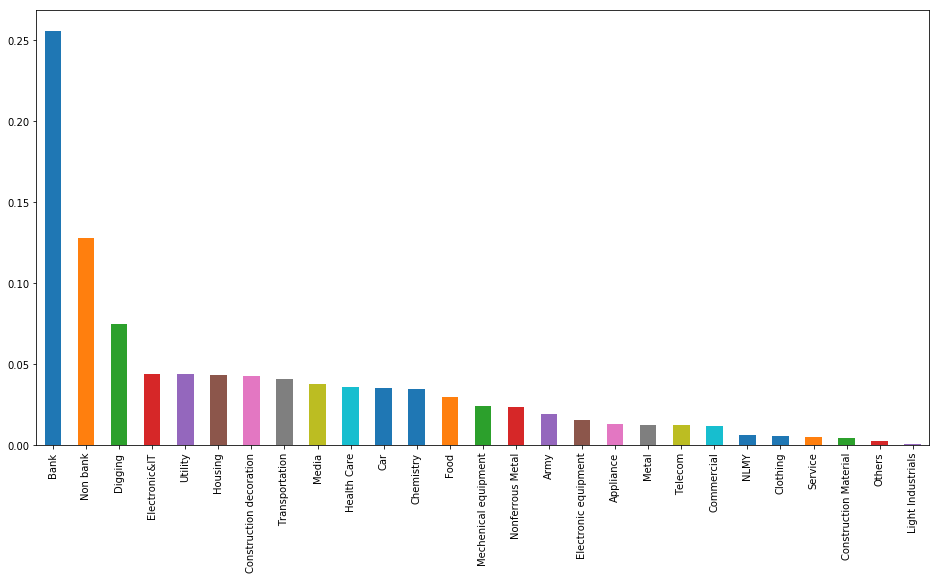

In [12]:
TARGET_DATE = 20151207
plt.figure(figsize = (16,8))
weight_industry.loc[TARGET_DATE].sort_values(ascending = False).plot.bar()
print(weight_industry.loc[TARGET_DATE].sort_values(ascending = False))

## 回测

## 中性化函数

In [16]:
def cs_neutralize(input_array, size_array):
    
    var_Y = input_array.copy()
    var_size = size_array.copy()
    
    var_X = var_size
    var_X.columns = ['size']
    var_X_const = sm.add_constant(var_X)

    regressPanel = pd.concat([var_Y, var_X_const], axis = 1)
    regressPanel = regressPanel.dropna()
    var_Y = regressPanel.iloc[:, 0]
    var_X = regressPanel.iloc[:, 1:3]    

    # OLS regression
    regressmodel = sm.OLS(var_Y, var_X)
    results = regressmodel.fit()
    return results.resid    

def group_demean_regress(dv, signal, group, new_name, is_quarterly = False):
    
    df_goal   = dv.get_ts(signal)
    df_output = df_goal.copy()
    
    industry = dv.get_ts(group)
    log_tot_mv = np.log(dv.get_ts('total_mv'))

    for i in range(len(df_output)):
        df_output.iloc[i, :] = cs_neutralize(df_goal.iloc[i, :], log_tot_mv.iloc[i, :])

    # insert into dv
    dv.remove_field(new_name)
    dv.append_df(df_output, new_name, is_quarterly = is_quarterly)

In [17]:
group_demean_regress(dv, 'pe_ttm', 'sw1', 'pe_ttm_size', is_quarterly = False)

Field name [pe_ttm_size] does not exist. Stop remove_field.


In [18]:
# 在全指数中排序
dv.add_formula('pct_pe', 'Percentile(pe_ttm)', is_quarterly = False)
# 在行业内排序（行业中性化）
dv.add_formula('gpct_pe', 'GroupPercentile(pe_ttm, sw1)', is_quarterly = False)
# 将pe市值中性化后在全指数中排序（市值中性化）
dv.add_formula('pct_pe_norm', 'Percentile(pe_ttm_size)', is_quarterly = False)

Field [pct_pe] is overwritten.
Field [gpct_pe] is overwritten.


## 策略1： 选择指数成份股中pe最低10%的股票

In [ ]:
def select_func1(context, user_options=None):
    snap = context.snapshot
    score = snap[['pe_ttm', 'pct_pe', 'gpct_pe']]

    score = score[score['pe_ttm'] >= 5]
    score = score[score['pct_pe'] <= 0.1]
    res = pd.merge(left=snap[['pe_ttm']], right=score[['pct_pe']], how='left', left_index=True, right_index=True)
    res['pct_pe'] = ~res['pct_pe'].isnull()
    res = res[['pct_pe']]

#     show_selected(res)

    context.storage['res'] = res
#     print(res)
    

    return res

## 策略2： 选择行业中pe最低10%的股票（行业中性化）

In [ ]:
def select_func2(context, user_options=None):
    snap = context.snapshot
    score = snap[['pe_ttm', 'pct_pe', 'gpct_pe']]

    score = score[score['pe_ttm'] >= 5]
    score = score[score['gpct_pe'] <= 0.1]
    res = pd.merge(left=snap[['pe_ttm']], right=score[['pct_pe']], how='left', left_index=True, right_index=True)
    res['pct_pe'] = ~res['pct_pe'].isnull()
    res = res[['pct_pe']]

#     show_selected(res)

    context.storage['res'] = res
#     print(res)
    

    return res

## 策略3： 将pe进行市值中性化处理后选最低10%的股票

In [19]:
def select_func3(context, user_options=None):
    snap = context.snapshot
    score = snap[['pe_ttm', 'pct_pe', 'gpct_pe', 'pct_pe_norm']]

    score = score[score['pe_ttm'] >= 5]
    score = score[score['pct_pe_norm'] <= 0.1]
    res = pd.merge(left=snap[['pe_ttm']], right=score[['pct_pe']], how='left', left_index=True, right_index=True)
    res['pct_pe'] = ~res['pct_pe'].isnull()
    res = res[['pct_pe']]

#     show_selected(res)

    context.storage['res'] = res
#     print(res)
    

    return res

In [20]:
backtest_props = {# start and end date of back-test
                  "start_date": START_DATE,
                  "end_date": END_DATE,
                  # re-balance period length
                  "period": "day",
                  "n_periods": 5,
                  # benchmark and universe
                  "benchmark": UNIVERSE,
                  "universe": UNIVERSE,
                  # Amount of money at the start of back-test
                  "init_balance": 1e8,
                  # Amount of money at the start of back-test
                  "position_ratio": 1.0,
                  "commission_rate": 15e-4,
                  }
backtest_props.update(data_config)

my_selector = model.StockSelector()
my_selector.add_filter('selector', select_func3)

# We use trade_api to send orders
trade_api = AlphaTradeApi()
# This is our strategy
strategy = AlphaStrategy(stock_selector=my_selector,
                         pc_method='index_weight')
# PortfolioManager helps us to manage tasks, orders and calculate positions
pm = PortfolioManager()
# BacktestInstance is in charge of running the back-test
bt = AlphaBacktestInstance()

# Public variables are stored in context. We can also store anything in it
context = model.Context(dataview=dv, instance=bt, strategy=strategy, trade_api=trade_api, pm=pm)
my_selector.register_context(context)
#signal_model.register_context(context)

bt.init_from_config(backtest_props)
bt.run_alpha()

# After finishing back-test, we save trade results into a folder
bt.save_results(folder_path=backtest_result_folder)

# Analyzer help us calculate various trade statistics according to trade results.
# All the calculation results will be stored as its members.
ta = ana.AlphaAnalyzer()

ta.initialize(dataview=dv,
              file_folder=backtest_result_folder)

ta.do_analyze(result_dir=backtest_result_folder,
              selected_sec=[])

### 注：看报告的两种方法：（1）在本地运行，则直接打开html文件即可。 （2）在服务器上： 文件在：notebook/output/dataview2017之下，点开后，将路径中的”edit"替换为“files"

AlphaStrategy Initialized.
Run alpha backtest from 20151207 to 20180531
=======new day 20151208
Before 20151208 re-balance: available cash all = 1.0000e+08
=======new day 20151215
Before 20151215 re-balance: available cash all = 1.0239e+08
=======new day 20151222
Before 20151222 re-balance: available cash all = 1.0670e+08
=======new day 20151229
Before 20151229 re-balance: available cash all = 1.0365e+08
=======new day 20160106
Before 20160106 re-balance: available cash all = 9.6038e+07
=======new day 20160113
Before 20160113 re-balance: available cash all = 8.8431e+07
=======new day 20160120
Before 20160120 re-balance: available cash all = 8.7166e+07
=======new day 20160127
Before 20160127 re-balance: available cash all = 8.2564e+07
=======new day 20160203
Before 20160203 re-balance: available cash all = 8.2241e+07
=======new day 20160217
Before 20160217 re-balance: available cash all = 8.4540e+07
=======new day 20160224
Before 20160224 re-balance: available cash all = 8.5355e+07
====

Before 20171201 re-balance: available cash all = 1.2416e+08
=======new day 20171208
Before 20171208 re-balance: available cash all = 1.2290e+08
=======new day 20171215
Before 20171215 re-balance: available cash all = 1.2034e+08
=======new day 20171222
Before 20171222 re-balance: available cash all = 1.1854e+08
=======new day 20171229
Before 20171229 re-balance: available cash all = 1.2099e+08
=======new day 20180108
Before 20180108 re-balance: available cash all = 1.2875e+08
=======new day 20180115
Before 20180115 re-balance: available cash all = 1.2708e+08
=======new day 20180122
Before 20180122 re-balance: available cash all = 1.3377e+08
=======new day 20180129
Before 20180129 re-balance: available cash all = 1.3566e+08
=======new day 20180205
Before 20180205 re-balance: available cash all = 1.3395e+08
=======new day 20180212
Before 20180212 re-balance: available cash all = 1.2040e+08
=======new day 20180226
Before 20180226 re-balance: available cash all = 1.2535e+08
=======new day 2